In [8]:
from pykalman import KalmanFilter
import numpy as np

def _determine_dimensionality(arrays_and_dims, n_dim_default):
    """Helper function to determine the dimensionality of the state or observation space."""
    for array, convert_func, axis in arrays_and_dims:
        if array is not None:
            return convert_func(array).shape[axis]
    if n_dim_default is not None:
        return n_dim_default
    raise ValueError("Could not determine dimensionality from inputs")

class MaskedKalmanFilter(KalmanFilter):
    def __init__(self, transition_matrices=None, observation_matrices=None,
                 transition_covariance=None, observation_covariance=None,
                 transition_offsets=None, observation_offsets=None,
                 initial_state_mean=None, initial_state_covariance=None,
                 random_state=None, em_vars=None, n_dim_state=None, n_dim_obs=None):
        
        # Determine the size of the state and observation spaces
        n_dim_state = _determine_dimensionality(
            [(transition_matrices, np.atleast_2d, -2),
             (transition_offsets, np.atleast_1d, -1),
             (transition_covariance, np.atleast_2d, -2),
             (initial_state_mean, np.atleast_1d, -1),
             (initial_state_covariance, np.atleast_2d, -2),
             (observation_matrices, np.atleast_2d, -1)],
            n_dim_state
        )
        n_dim_obs = _determine_dimensionality(
            [(observation_matrices, np.atleast_2d, -2),
             (observation_offsets, np.atleast_1d, -1),
             (observation_covariance, np.atleast_2d, -2)],
            n_dim_obs
        )

        # Set default EM variables if none are provided
        if em_vars is None:
            em_vars = ['transition_covariance', 'observation_covariance',
                       'initial_state_mean', 'initial_state_covariance']

        # Pass the parameters to the base KalmanFilter class
        super().__init__(
            transition_matrices=transition_matrices,
            observation_matrices=observation_matrices,
            transition_covariance=transition_covariance,
            observation_covariance=observation_covariance,
            transition_offsets=transition_offsets,
            observation_offsets=observation_offsets,
            initial_state_mean=initial_state_mean,
            initial_state_covariance=initial_state_covariance,
            random_state=random_state,
            em_vars=em_vars,
            n_dim_state=n_dim_state,
            n_dim_obs=n_dim_obs
        )

        # Store the dimensions
        self.n_dim_state = n_dim_state
        self.n_dim_obs = n_dim_obs

    def filter(self, X):
        """Apply the Kalman Filter with support for masked arrays."""
        # Create a mask to handle NaN values (masked observations)
        mask = np.isnan(X)
        X_masked = np.ma.array(X, mask=mask)

        # Call the original filter method from the base class
        return super().filter(X_masked)

    def em(self, X, mask=None, n_iter=10, em_vars=None):
        """Apply the EM algorithm to handle masked data."""
        # If mask is provided, apply it to the data
        if mask is not None:
            X_masked = np.ma.array(X, mask=mask)
        else:
            X_masked = np.ma.masked_invalid(X)

        # Set default EM variables if none are provided
        if em_vars is None:
            em_vars = ['transition_covariance', 'observation_covariance',
                       'initial_state_mean', 'initial_state_covariance']
        
        # Call the original EM method with the masked data
        return super().em(X_masked, n_iter=n_iter, em_vars=em_vars)


In [36]:
# Example input with missing (NaN) values
X = np.array([[1.0, 2.0, np.nan],
              [4.0, 5.0, 6.0],
              [7.0, 8.0, np.nan]])

# Initialize the custom Kalman filter
kf = MaskedKalmanFilter(transition_matrices=np.eye(3),
                        observation_matrices=np.eye(3))

# Perform EM with masked data
kf.em(X, n_iter=10)


Epoch [10/500], Loss: -46.0538
Epoch [20/500], Loss: -235.0841
Epoch [30/500], Loss: -436.8885
Epoch [40/500], Loss: -578.6329
Epoch [50/500], Loss: -683.6255
Epoch [60/500], Loss: -774.8167
Epoch [70/500], Loss: -858.1703
Epoch [80/500], Loss: -937.6031
Epoch [90/500], Loss: -1014.5120
Epoch [100/500], Loss: -1089.5682
Epoch [110/500], Loss: -1163.2107
Epoch [120/500], Loss: -1235.7423
Epoch [130/500], Loss: -1307.3678
Epoch [140/500], Loss: -1378.2499
Epoch [150/500], Loss: -1448.5087
Epoch [160/500], Loss: -1518.2399
Epoch [170/500], Loss: -1587.5177
Epoch [180/500], Loss: -1656.4011
Epoch [190/500], Loss: -1724.9406
Epoch [200/500], Loss: -1793.1748
Epoch [210/500], Loss: -1861.1385
Epoch [220/500], Loss: -1928.8593
Epoch [230/500], Loss: -1996.3615
Epoch [240/500], Loss: -2063.6663
Epoch [250/500], Loss: -2130.7908
Epoch [260/500], Loss: -2197.7510
Epoch [270/500], Loss: -2264.5605
Epoch [280/500], Loss: -2331.2314
Epoch [290/500], Loss: -2397.7747
Epoch [300/500], Loss: -2464.198

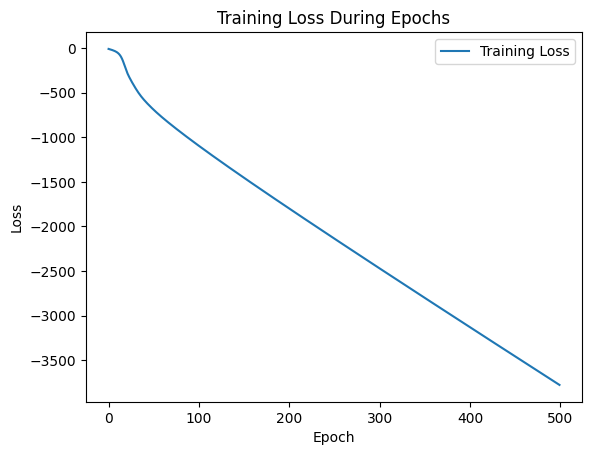

Test Loss: -3722.0078
Accuracy: 0.0161
AUC: 0.5000


In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

# Load and preprocess your dataset
data_cleaned = pd.read_csv('../../../Data_processing/Outputs/train.csv')
data_cleaned = data_cleaned.loc[data_cleaned['usubjid'].isin(data_cleaned[data_cleaned['label'] == 1]["usubjid"].unique())]
data_cleaned.dropna(inplace=True)

# Feature selection
features = ['aval_AlloMap', 'aval_AlloSure', 'ady_dna']
target = 'label'

# Group data by 'usubjid' and shuffle within groups to maintain sequence structure
grouped_data = data_cleaned.groupby('usubjid')
shuffled_df = grouped_data.sample(frac=1, random_state=42).sort_values(['usubjid', 'ady_dna'])
grouped_data = shuffled_df.reset_index(drop=True).groupby('usubjid')

# Prepare inputs (X) and labels (y)
X_grouped = [group[features].values for name, group in grouped_data]
y_grouped = [group[target].values for name, group in grouped_data]

# Padding sequences to max length and creating masks
max_len = max([len(seq) for seq in X_grouped])
X_padded = np.array([np.pad(seq, ((0, max_len - len(seq)), (0, 0)), 'constant', constant_values=999999) for seq in X_grouped])
y_padded = np.array([np.pad(seq, (0, max_len - len(seq)), 'constant', constant_values=99) for seq in y_grouped])

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_padded, test_size=0.2, random_state=42)

# Normalize features
scaler = MinMaxScaler()
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])  # Reshape to 2D for scaling
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

X_train_reshaped = scaler.fit_transform(X_train_reshaped)
X_test_reshaped = scaler.transform(X_test_reshaped)

X_train_scaled = X_train_reshaped.reshape(X_train.shape)
X_test_scaled = X_test_reshaped.reshape(X_test.shape)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h_lstm, _ = self.lstm(x)  # LSTM output
        out = self.fc(h_lstm[:, -1, :])  # Take last time step's output
        return out

# Hyperparameters
input_dim = X_train.shape[2]  # Number of features (3: aval_AlloMap, aval_AlloSure, ady_dna)
hidden_dim = 64  # Number of hidden units in LSTM
output_dim = 1   # Binary classification (label: 0 or 1)
num_layers = 2   # Number of LSTM layers
num_epochs = 500
learning_rate = 0.001

# Model, loss function, and optimizer
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store loss for visualization
train_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train_tensor)
    loss = criterion(outputs.squeeze(), y_train_tensor[:, -1].squeeze())  # Use last time step's target
    
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())  # Store loss for each epoch
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Visualization of training loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss During Epochs')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs.squeeze(), y_test_tensor[:, -1].squeeze())
    print(f'Test Loss: {test_loss.item():.4f}')

# Converting predictions to probabilities and binary labels
pred_probs = torch.sigmoid(test_outputs).numpy()  # Sigmoid for probability output
pred_labels = (pred_probs > 0.5).astype(int)  # Convert probabilities to binary labels

# Calculate Accuracy
y_true = y_test_tensor[:, -1].numpy()  # True labels from the last time step
accuracy = accuracy_score(y_true, pred_labels)
print(f'Accuracy: {accuracy:.4f}')

# Calculate AUC
auc_score = roc_auc_score(y_true, pred_probs)
print(f'AUC: {auc_score:.4f}')

